In [78]:
print("Versions of the runtime and packages used for this assignment:")
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import skfuzzy as fuzz
print("scikit-fuzzy version: {}".format(fuzz.__version__))

print("-------------------------------------------------------")
print("When run on my machine the following versions were used:")
print("Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]")
print("pandas version: 2.1.2")
print("matplotlib version: 3.9.2")
print("NumPy version: 1.24.3")
print("scikit-fuzzy version: 0.5.0")

Versions of the runtime and packages used for this assignment:
Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.2.3
matplotlib version: 3.10.1
NumPy version: 2.2.3
scikit-fuzzy version: 0.5.0
-------------------------------------------------------
When run on my machine the following versions were used:
Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.1.2
matplotlib version: 3.9.2
NumPy version: 1.24.3
scikit-fuzzy version: 0.5.0


### Define domain of input variables

In [79]:
# import libraries
from skfuzzy import control as ctrl

# Each input variable has an associated universe of discourse which represents the range of values that the variable can take on
# Define the universe of discourse for each input variable

# Given the minimum and maximum values for a given domain
# create a range of values that includes all integers less than or equal to the maximum value and greater than or equal to the minimum value
def create_range(minimum_value, maximum_value):
    increment_by_one = 1
    return np.arange(minimum_value, maximum_value + 1, increment_by_one)

zero_lessons = 0
one_hundred_lessons = 100
user_level_universe = create_range(
    minimum_value=zero_lessons,
    maximum_value=one_hundred_lessons
)

zero_percent = 0
one_hundred_percent = 100
accuracy_universe = create_range(
    minimum_value=zero_percent,
    maximum_value=one_hundred_percent
)

### Define fuzzy antecedants

In [80]:
# Define the antecedents for each input variable that represent the fuzzy conditions that must be satisfied for a rule in the system to be applied
# Unlike conditions in traditional logic, fuzzy conditions can be partially satisfied
# For example, instead of saying "if they completed 80 lessons" we can say "if they are experienced"
user_level = ctrl.Antecedent(user_level_universe, 'user_level')
accuracy = ctrl.Antecedent(accuracy_universe, 'accuracy')

### Define the consequent

In [81]:
# Define the universe of discourse for the output variable
easiest_difficulty = 1
hardest_difficulty = 100
lesson_difficulty_universe = create_range(
    minimum_value=easiest_difficulty,
    maximum_value=hardest_difficulty
)

# Define the consequent that represents the calculation of the lesson difficulty
# The output is calculated when the antecedents are satisfied
lesson_difficulty = ctrl.Consequent(lesson_difficulty_universe, 'lesson_difficulty')

### Define the fuzzy sets

In [82]:
# Define fuzzy sets for each input variable
# Represents categories that don't have precise boundaries
# Unlike traditional sets, fuzzy sets can have elements with partial membership represented by a value between 0 and 1
# For example, a completing 20 lessons might be 0.2 in the "beginner" set, 0.8 in the "intermediate" set, and 0 in the "expert" set

beginner = "beginner"
intermediate = "intermediate"
expert = "expert"
user_level_categories = [beginner, intermediate, expert]

low = 'low'
medium = 'medium'
high = 'high'
accuracy_categories = [low, medium, high]

### Membership functions for antecedents

In [83]:
# Define membership functions for the antecedents
# Used to fuzzify the input and relate precise values to degrees of membership in fuzzy sets

# Define a guassian membership function for each of the fuzzy sets
# The shape of the membership function is defined by the mean and standard deviation
# This shape is ideal because there are no sharp boundaries between the categories despite the fact that the categories are distinct
# The mean is the center of the distribution and the standard deviation is the spread of the distribution

fifty_lessons = 50

user_level[beginner] = fuzz.gaussmf(user_level.universe, mean=20, sigma=20)
user_level[intermediate] = fuzz.gaussmf(user_level.universe, mean=50, sigma=20)
user_level[expert] = fuzz.gaussmf(user_level.universe, mean=80, sigma=20)

accuracy[low] = fuzz.gaussmf(accuracy.universe, mean=20, sigma=10)
accuracy[medium] = fuzz.gaussmf(accuracy.universe, mean=50, sigma=10)
accuracy[high] = fuzz.gaussmf(accuracy.universe, mean=80, sigma=10)

### Visualize antecendent membership functions

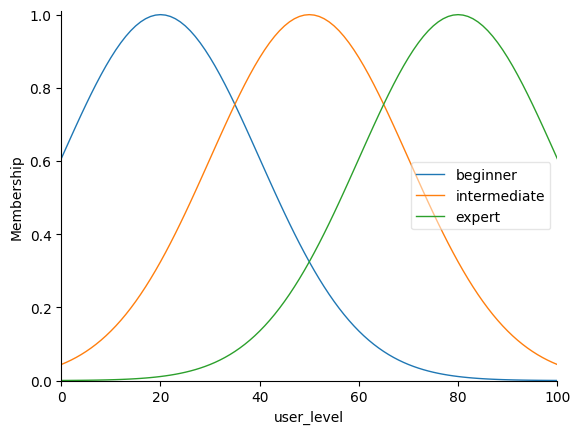

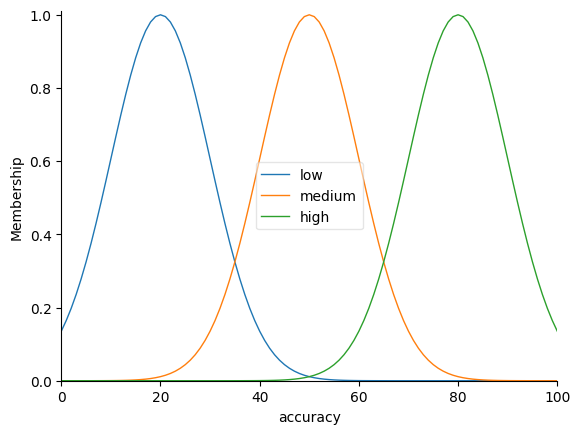

In [84]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="skfuzzy.control.fuzzyvariable")


# Visualize the membership functions
user_level.view()
accuracy.view()


### Membership functions for consequent

In [85]:
# Define membership functions for the consequent.
# Represents how the output variable relates to a degree of membership in a fuzzy set.
# Unlike, membership functions for antecedents,
#  this membership function is used to defuzzify the output to output a precise lesson difficulty

easy = "easy"
moderate = "moderate"
hard = "hard"

lesson_difficulty.automf(
    names=[easy, moderate, hard],
)

### Visualize consequent membership function

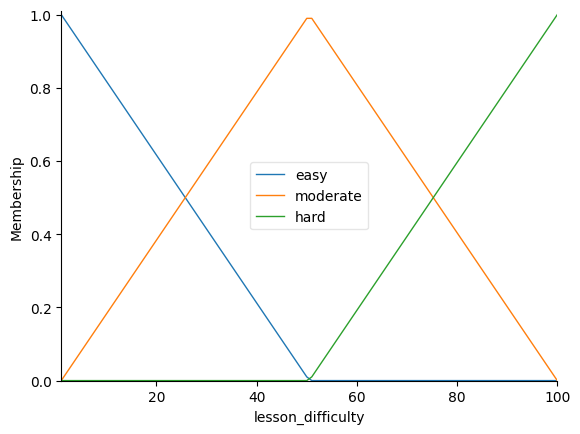

In [86]:
lesson_difficulty.view()

### Define the rules for the controller

In [87]:
# Create a dictionary to map user model descriptions to lesson difficulty categories
# This will be used to generate rules for the fuzzy logic controller
lesson_difficulty_category_by_user_model_description = {
    (beginner, low): easy,
    (beginner, medium): easy,
    (beginner, high): easy,
    (intermediate, low): easy,
    (intermediate, medium): moderate,
    (intermediate, high): hard,
    (expert, low): moderate,
    (expert, medium): hard,
    (expert, high): hard,
}

# Given a user model description, generate a rule for the fuzzy logic controller
# The conditions of the rule will determined by the fuzzy sets of the input variables
# The consequent of the rule will be the target lesson difficulty
def generate_rule_for(user_model_description):
    user_level_category, accuracy_category = user_model_description
    lesson_difficulty_conditions = (
        user_level[user_level_category] &
        accuracy[accuracy_category]
    )
    lesson_difficulty_category = lesson_difficulty_category_by_user_model_description[user_model_description]
    prediction = lesson_difficulty[lesson_difficulty_category]
    return ctrl.Rule(lesson_difficulty_conditions, prediction)

# Generate rules for all possible user model descriptions
rules = [
    generate_rule_for(user_model_description)
    for user_model_description
    in lesson_difficulty_category_by_user_model_description
]


In [88]:
# Create a control system and simulation using Mamdani inference
model = ctrl.ControlSystem(rules)
simulation = ctrl.ControlSystemSimulation(model)

In [89]:
# Given the precise input values return predicted lesson difficulty
def predict_lesson_difficulty_given_precise_inputs(
        user_level_value,
        accuracy_value
    ):
    # Provide inputs to the ControlSystem using Antecedent labels
    simulation.input['user_level'] = user_level_value
    simulation.input['accuracy'] = accuracy_value
    # Compute the output using the ControlSystem
    # Applies centroid defuzzification to convert the fuzzy output to a precise value
    simulation.compute()
    # Return the computed wash time
    return simulation.output['lesson_difficulty']

# Given a precise wash time, return the fuzzy set with the highest membership value
# This represents the category of wash time that the precise wash time is most likely to belong to
def get_fuzzy_set_with_highest_membership_value(precise_lesson_difficulty):
    # Compute the membership value of the precise wash time in each fuzzy set
    membership_values = {
        easy: fuzz.interp_membership(lesson_difficulty.universe, lesson_difficulty[easy].mf, precise_lesson_difficulty),
        moderate: fuzz.interp_membership(lesson_difficulty.universe, lesson_difficulty[moderate].mf, precise_lesson_difficulty),
        hard: fuzz.interp_membership(lesson_difficulty.universe, lesson_difficulty[hard].mf, precise_lesson_difficulty)
    }
    # Select the name of the fuzzy set with the highest membership value
    fuzzy_set_with_highest_membership_value = max(membership_values, key=membership_values.get)
    # Return the name of the fuzzy set with the highest membership value
    return fuzzy_set_with_highest_membership_value

# Create a friendly description of the precise wash time and the fuzzy set it most strongly belongs to
def build_lesson_difficulty_description(precise_lesson_difficulty):
    fuzzy_set = get_fuzzy_set_with_highest_membership_value(precise_lesson_difficulty)
    return f"{precise_lesson_difficulty:.2f} difficulty, which is considered a {fuzzy_set} lesson"


25.16 difficulty, which is considered a easy lesson


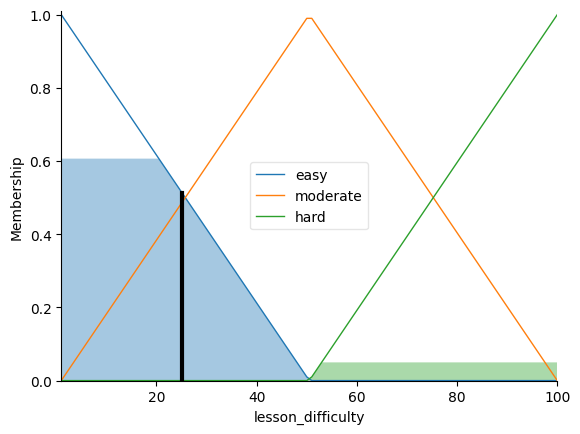

In [90]:
# Compute the wash time given precise input values
precise_lesson_difficulty = predict_lesson_difficulty_given_precise_inputs(
    user_level_value=1,
    accuracy_value=90
)
print(build_lesson_difficulty_description(precise_lesson_difficulty))
# Visualize the fuzzy set with the highest membership value for the precise wash time
lesson_difficulty.view(sim=simulation)

### Simulate with fuzzy inputs

50.50 difficulty, which is considered a moderate lesson


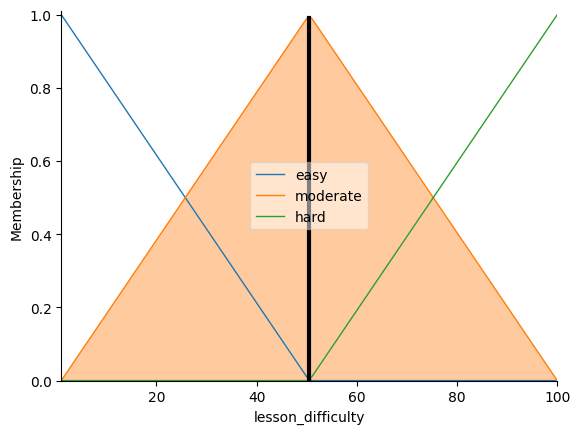

In [91]:
# Given the fuzzy sets of each input value return the wash time
def predict_lesson_difficulty_given_fuzzy_inputs(
        user_level_category,
        accuracy_category
    ):
    # Derive the precise input values from the fuzzy input sets
    precise_user_level = user_level.terms[user_level_category]
    precise_accuracy = accuracy.terms[accuracy_category]
    # Simulate with the precise input values
    return predict_lesson_difficulty_given_precise_inputs(
        precise_user_level,
        precise_accuracy
    )

# Compute the was time given the fuzzy input values for soil level, load size, and water temperature
precise_lesson_difficulty = predict_lesson_difficulty_given_fuzzy_inputs(
    user_level_category=expert,
    accuracy_category=low
)
print(build_lesson_difficulty_description(precise_lesson_difficulty))
lesson_difficulty.view(sim=simulation)

In [92]:
input_values = [
    (beginner, high),
    (beginner, low),
    (intermediate, high),
    (expert, low),
    (expert, high),
]
print(f"{'User Level':<16}{'Accuracy':<16}{'Lesson Difficulty':<16}")
for user_level_category, accuracy_category in input_values:
    prediction = predict_lesson_difficulty_given_fuzzy_inputs(
        user_level_category=user_level_category,
        accuracy_category=accuracy_category
    )
    print(f"{user_level_category:<16}{accuracy_category:<16}{get_fuzzy_set_with_highest_membership_value(prediction):<16}")

User Level      Accuracy        Lesson Difficulty
beginner        high            easy            
beginner        low             easy            
intermediate    high            hard            
expert          low             moderate        
expert          high            hard            


Serialize the model and write it to disk. This will allow the model to be loaded in the web server

In [93]:
import pickle

with open('../data/model.pkl', 'wb') as model_file:
    pickle.dump(
        {
            'model': model,
            'lesson_difficulty': lesson_difficulty,
            'user_level': user_level,
            'accuracy': accuracy,
        },
        model_file
    )